## Load Dependancies

In [26]:
project_name = 'dhcp'
import os
#get current working directory
cwd = os.getcwd()
git_dir = cwd.split(project_name)[0] + project_name
import sys

#add git_dir to path
sys.path.append(git_dir)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dhcp_params as params
from scipy import stats

from sklearn.manifold import MDS
import pdb

import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [2]:
atlas = 'wang'


#load atlast name and roi labels
atlas_info = params.load_atlas_info(atlas)
group_params = params.load_group_params('infant')

sub_info = group_params.sub_list
age_groups = ['infant', 'adult']

#color code rois by network
#inds 1-7 are EVC
#inds 8-11 are ventral
#inds 12-17 are lateral
#inds 18-25 are dorsal

#add networks to roi labels
#roi_labels['network'] = ['Occipital']*6 + ['Ventral']*5 + ['Lateral']*6 + ['Dorsal']*7

networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
network_colors = ['#fd0000', '#be00fd', '#1105d8', '#00fd00']

age_bins = [26,33, 38,42,46]
age_groups = ['Pre-Term','Early-Term','Term','Post-Term']

roi_labels = atlas_info.roi_labels

#expand roi labels to include hemis
all_rois = []
all_networks = []


all_rois = []
all_networks = []
for roi in roi_labels['label']:
    for hemi in params.hemis:
        all_rois.append(f'{hemi}_{roi}')
        all_networks.append(roi_labels[roi_labels['label'] == roi]['network'].values[0])




## Load and process correlations

In [8]:
df_summary = pd.read_csv(f'{group_params.out_dir}/derivatives/{atlas}/infant_adult_{atlas}_similarity.csv')
#add age column
df_summary['age'] = (df_summary['scan_age'] - df_summary['birth_age']) * 7

#load adult noise ceilings
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')

df_noise_network = adult_noise_ceilings.groupby(['network1', 'roi_similarity'])['corr'].mean().reset_index()
#add standard error col
df_noise_network['std'] = adult_noise_ceilings.groupby(['network1', 'roi_similarity'])['corr'].std().reset_index()['corr']/np.sqrt(29)
#only keep same
df_noise_network = df_noise_network[df_noise_network['roi_similarity'] == 'same'] 


df_noise_roi = adult_noise_ceilings.groupby(['roi1', 'roi_similarity'])['corr'].mean().reset_index()
#add standard error col
df_noise_roi['std'] = adult_noise_ceilings.groupby(['roi1', 'roi_similarity'])['corr'].std().reset_index()['corr']/np.sqrt(29)
df_noise_roi = df_noise_roi[df_noise_roi['roi_similarity'] =='same']



#### Analyze subs scanned on day 1

In [14]:
#extract only subs with age <= 1
#groups at network level
df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()

#groups at roi level
df_roi_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_roi','adult_roi','adult_network', 'roi_similarity'])['corr'].mean().reset_index()

#extact only subs with age <= 1
df_network_summary = df_network_summary[df_network_summary['age'] <= 1]
df_roi_summary = df_roi_summary[df_roi_summary['age'] <= 1]

#group roi summary by roi
df_roi_summary = df_roi_summary.groupby(['infant_roi','adult_roi','adult_network', 'roi_similarity'])['corr'].mean().reset_index()



#### Plot Network corrs

infant_network  network_similarity
Occipital       same                  0.47658
                diff                  0.03388
Name: corr, dtype: float64
infant_network  network_similarity
Ventral         same                  0.251887
                diff                  0.029365
Name: corr, dtype: float64
infant_network  network_similarity
Lateral         same                  0.290766
                diff                  0.101457
Name: corr, dtype: float64
infant_network  network_similarity
Dorsal          same                  0.411532
                diff                 -0.063913
Name: corr, dtype: float64


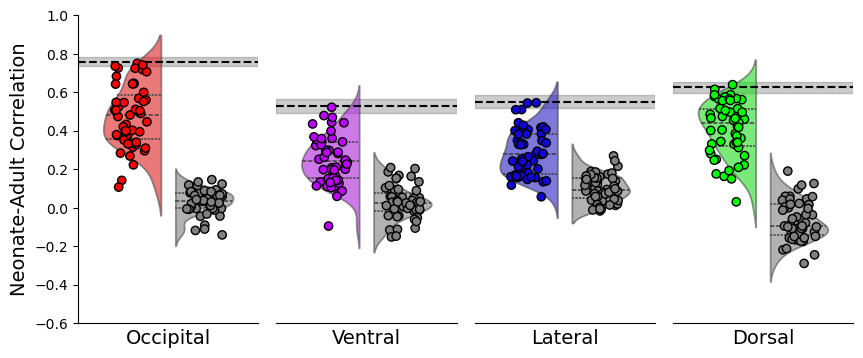

In [15]:
'''plot sub data at network level'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','diff']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['#00fd00', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['infant_network']==network_order[i]) & (df_network_summary['roi_similarity'] == 'same') | (df_network_summary['infant_network']==network_order[i]) & (df_network_summary['network_similarity'] == 'diff')]
    
    print(curr_data.groupby(['infant_network','network_similarity'])['corr'].mean())
    
    #add horizontal line at noise ceiling
    ax[i].axhline(y=df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0], color = 'k', linestyle = '--')
    #add opaque rectangle behind noise ceiling with width of the standard deviation
    ax[i].axhspan(df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]-df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
                  df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]+df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
                  alpha=0.2, color='k')
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'infant_network', y= 'corr', hue='network_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'infant_network', y= 'corr', hue = 'network_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.6,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Neonate-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

#### Plot ROI corrs

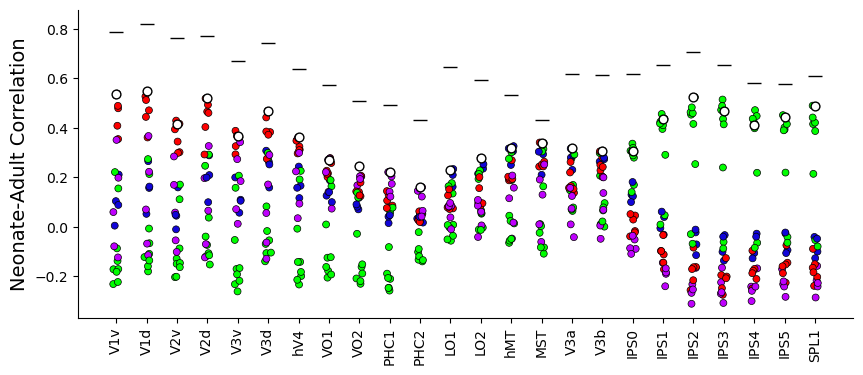

In [16]:
'''Plot data at roi level'''
network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_roi_summary['infant_roi'] = pd.Categorical(df_roi_summary['infant_roi'], categories=roi_labels['label'], ordered=True)
df_roi_summary['adult_network'] = pd.Categorical(df_roi_summary['adult_network'], categories=network_order, ordered=True)

df_roi_same = df_roi_summary[df_roi_summary['infant_roi']==df_roi_summary['adult_roi']]



sns.scatterplot(data = df_roi_same, x = 'infant_roi', y = 'corr', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = df_roi_summary, x = 'infant_roi', y = 'corr', hue = 'adult_network', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

#### Create network bar graphs

In [17]:
def plot_network_corr(summary_df,noise_ceiling_df = None):

    #capitalize network names
    #summary_df.columns = [net.capitalize() for net in summary_df.columns]

    #Replace EVC column with early vision
    #summary_df = summary_df.rename(columns = {'Evc':'EVC'})

    summary_df['infant_network'] = pd.Categorical(summary_df['infant_network'], categories=network_order, ordered=True)

    #plot summary_df
    ax = sns.barplot(data = summary_df, x = 'infant_network',y='corr', errorbar=('ci',95), edgecolor = 'k',palette = network_colors,
                    alpha = .5)
    sns.stripplot(data = summary_df,  x = 'infant_network',y='corr', edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                palette = network_colors, ax = ax)

    #add noise ceilings as dot above each bar
    if noise_ceiling_df is not None:
        for i, net in enumerate(networks):
            #add noise ceiling
            plt.plot(i, noise_ceiling_df[net].mean(), '_', color = 'gray', markersize = 15, markeredgecolor = 'k')

    #increase font size of x and y ticks
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)

    #add y label
    plt.ylabel('Correlation with adults', fontsize = 20)

    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')

    #remove top and right axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #make graph smaller
    plt.gcf().set_size_inches(5,8)

    #remove x axis label
    plt.xlabel('')

    plt.show()
    plt.pause(.001)


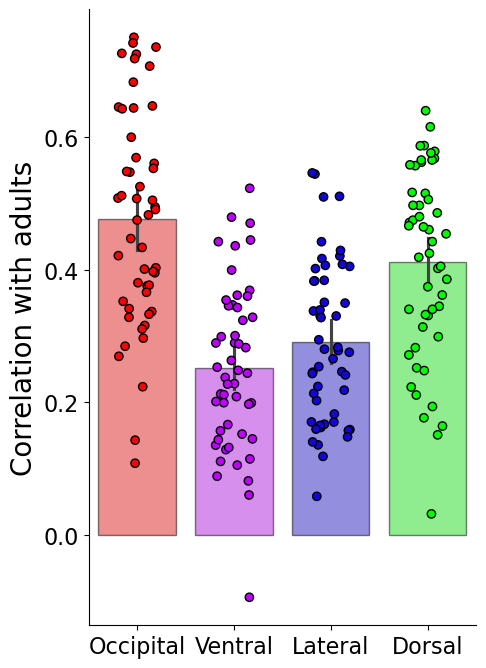

In [18]:
df_same_only = df_network_summary[df_network_summary['roi_similarity'] == 'same']

plot_network_corr(df_same_only,noise_ceiling_df = None)

#MAKE NOISE CORECTED BARS

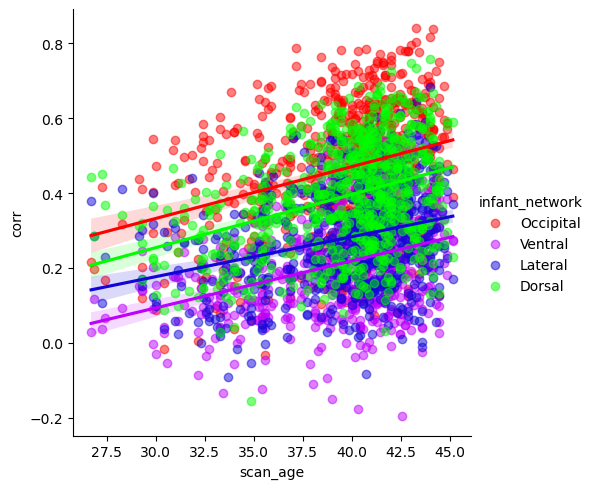

In [23]:
# create lmplots plotting correlation as a function of scan_age
df_network_summary = df_summary.groupby(['sub','ses', 'birth_age', 'scan_age','age','infant_network', 'roi_similarity','network_similarity'])['corr'].mean().reset_index()
df_same_only = df_network_summary[df_network_summary['roi_similarity'] == 'same']

#set network order as categorical and level order
df_same_only['infant_network'] = pd.Categorical(df_same_only['infant_network'], categories=network_order, ordered=True)


sns.lmplot(data = df_same_only, x = 'scan_age', y = 'corr',  hue = 'infant_network',  ci = 95, scatter_kws = {'alpha':.5},  palette = network_colors)

In [27]:
#regress out age and save residuals in new column
df_same_only['arealization_age_resid'] = np.nan
df_same_only['arealization_gestation_resid'] = np.nan
for network in networks:
    #regress out age
    curr_data = df_same_only[df_same_only['infant_network'] == network]
    X = stats.zscore(curr_data['age'])
    y = stats.zscore(curr_data['corr'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    df_same_only.loc[df_same_only['infant_network'] == network, 'arealization_age_resid'] = model.resid
    
    #regress out scan_age
    X = stats.zscore(curr_data['scan_age'])
    y = stats.zscore(curr_data['corr'])

    #fit linear model
    model = sm.OLS(y,X).fit()
    df_same_only.loc[df_same_only['infant_network'] == network, 'arealization_gestation_resid'] = model.resid

   
    

Text(39.10439763374485, 0.5, 'Arealization Index')

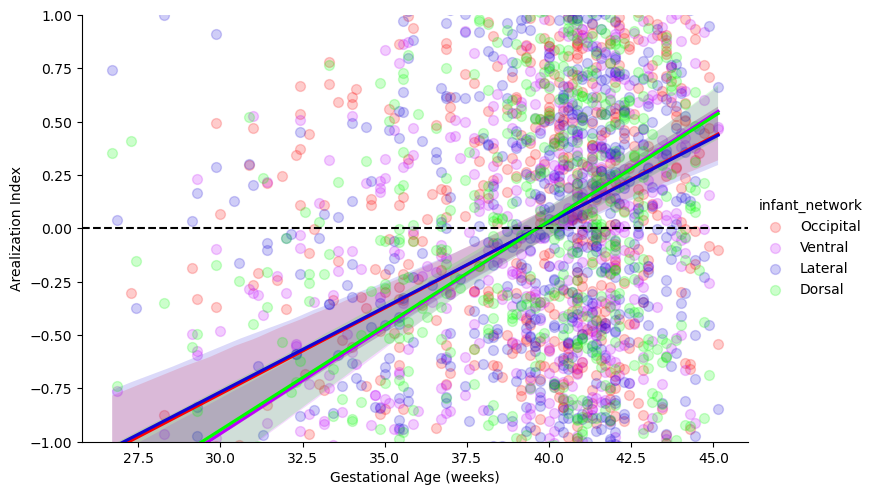

In [30]:
#make lmplots of residuals as a function of gestational age (scan_age), controlling for age since birth
sns.lmplot(data = df_same_only, x = 'scan_age', y = 'arealization_age_resid', hue = 'infant_network', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
#dotted line at 0
plt.axhline(y=0, color = 'black', linestyle = '--')

#set ylim
plt.ylim(-1,1)

# set x label to gestational age
plt.xlabel('Gestational Age (weeks)')
plt.ylabel('Arealization Index')

Text(39.10439763374485, 0.5, 'Arealization Index')

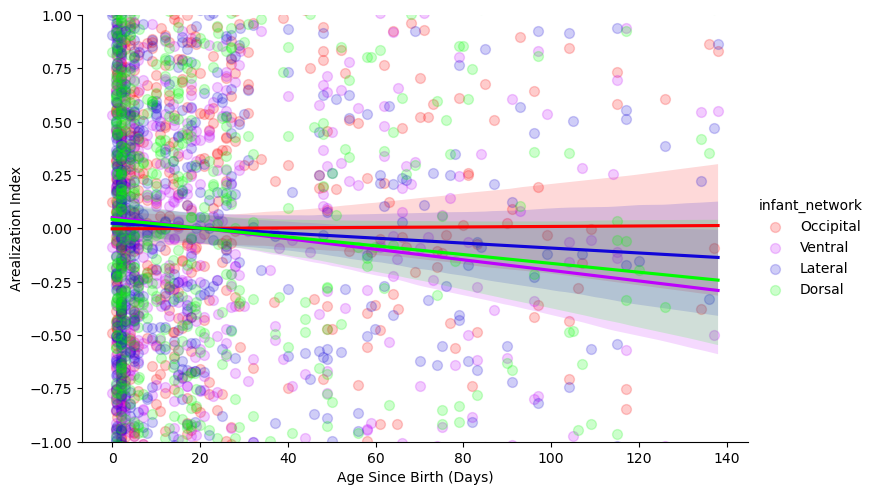

In [31]:
#plot residuals as a function of age since birth controlling for gestational age(scan_age)
sns.lmplot(data = df_same_only, x = 'age', y = 'arealization_gestation_resid', hue = 'infant_network', palette = network_colors, scatter_kws = {'s': 50,  'alpha':.2}, height = 5, aspect = 1.5)
plt.ylim(-1,1)

#set X label to age since birth
plt.xlabel('Age Since Birth (Days)')
plt.ylabel('Arealization Index')

## Measure Hierarchy

In [17]:
network_rois = [['V1v', 'V2v','V3v', 'hV4','VO1','VO2','PHC1','PHC2'], ['V1d', 'V2d','V3d', 'V3a','V3b','IPS0','IPS1','IPS2','IPS3','IPS4','IPS5','SPL1'], ['V1d', 'V2d','V3d', 'LO1','LO2','hMT', 'MST']]
networks = ['Ventral', 'Dorsal', 'Lateral']

hierarchy_num = pd.Series([1,1,2,2,3,3,4,5,6,7,8,4,5,6,7,4,5,6,7,8,9,10,11,12])

color_maps =[['#25044d', '#2a00ba', '#0833cd','#0e6896', '#0fa35c', '#55ee1a', '#efeb00', '#ff2200'], 
['#25044d', '#3000a6', '#0826d8', '#0826d8', '#118479', '#13c53f', '#8efa07', '#f8dd00', '#ff2200'],
['#25044d', '#1018db', '#0f6499', '#0dae53', '#9dfb03', '#ff2200']]

roi_labels['hierarchy_num'] = hierarchy_num

summary_type = '_fc'

#load seed correlations and summarize
df_summary = pd.read_csv(f'{git_dir}/results/infant_adult_roi_similarity{summary_type}.csv')

#replace TO1 with hMT
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#add sub column as index

df_roi_summary = df_summary.groupby(['sub','infant_roi','infant_network','roi_similarity'])['corr'].mean().reset_index()

#extract only same
df_roi_summary = df_roi_summary[df_roi_summary['roi_similarity'] == 'same']

df_roi_summary= df_roi_summary.reset_index()


df_noise = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#replace TO1 with hMT
#df_noise['roi'] = df_noise['roi'].replace('TO1', 'hMT')
df_noise_roi = df_noise.groupby(['roi1','roi_similarity'])['corr'].mean().reset_index()
df_noise_roi = df_noise_roi[df_noise_roi['roi_similarity'] == 'same']

#normalize each infant roi by the noise ceiling
df_roi_summary = df_roi_summary.merge(df_noise_roi, left_on='infant_roi', right_on='roi1')
df_roi_summary['corr_norm'] = df_roi_summary['corr_x']/df_roi_summary['corr_y']


#add column that has the hiearchy number for each infant_roi
for roi, num in zip(roi_labels['label'], roi_labels['hierarchy_num']):
    df_roi_summary.loc[df_roi_summary['infant_roi'] == roi, 'hierarchy_num'] = num

Ventral
['V1v', 'V2v', 'V3v', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2']


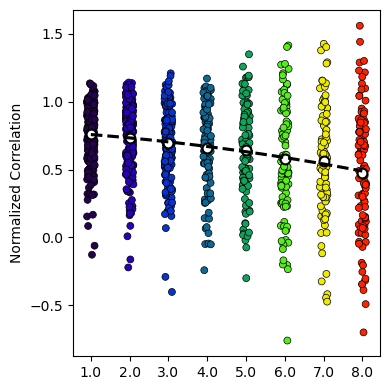

Dorsal
['V1d', 'V2d', 'V3d', 'V3a', 'V3b', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1']


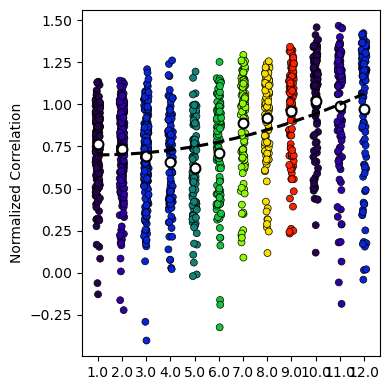

Lateral
['V1d', 'V2d', 'V3d', 'LO1', 'LO2', 'hMT', 'MST']


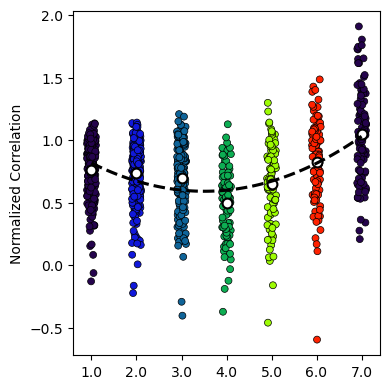

In [23]:
#add line for noise ceiling

for network, rois in zip(networks, network_rois):
    print(network)
    print(rois)
    curr_data = df_roi_summary[(df_roi_summary['infant_network'] == 'Occipital') | (df_roi_summary['infant_network'] == network)]

    #set curr_data infant_network to categorical with order network  roi
    curr_data['infant_roi'] = pd.Categorical(curr_data['infant_roi'], categories = rois, ordered = True)

    #set current color map
    curr_color_map = color_maps[networks.index(network)]
  



    #compute mean and sem for each roi
    curr_data_mean = curr_data.groupby('hierarchy_num')['corr_norm'].mean().reset_index()
    curr_data_mean['hierarchy_num'] = curr_data_mean['hierarchy_num'] -1
    


    
    #sns.scatterplot(data=curr_data, x='hierarchy_num', y='corr')
    #plot individual data
    sns.stripplot(data = curr_data, x = 'hierarchy_num', y = 'corr_norm', hue = 'hierarchy_num', palette= curr_color_map, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)
    #plt.plot(x,y, color = 'k', linestyle = '--',)
    
    #plot means for each category as individual points
    sns.scatterplot(data = curr_data_mean, x = 'hierarchy_num', y = 'corr_norm', color = 'white',edgecolor='k',linewidth =1.5,s = 50, zorder = 1)
    #plot as violin plot
    #sns.violinplot(data = curr_data, x = 'hierarchy_num', y = 'corr_norm', hue = 'hierarchy_num', palette = curr_color_map, alpha = .5, inner = 'quart')

    sns.regplot(data = curr_data_mean, x = 'hierarchy_num', y = 'corr_norm', scatter = False, color = 'k', ci = None, line_kws = {'linestyle':'--'}, order=2)

    #sns.scatterplot(curr_data_mean['hierarchy_num'], curr_data_mean['corr_norm'], color = 'white',edgecolors='k', s = 50, zorder = 1)

    #replace x-axis with roi names
    #plt.xticks(np.arange(len(rois)), rois, rotation = 90)

    
    plt.ylabel('Normalized Correlation')

    #remove x-axis label
    plt.xlabel('')
    
    
    plt.legend([],[], frameon=False)

    #set plot size
    plt.gcf().set_size_inches(4,4)
    plt.tight_layout()

    #plt.savefig(f'{git_dir}/figures/{network}_roi_hierarchy_correlations.png', dpi = 300)
    plt.pause(.001)

## Adult data

In [63]:
#replace TO1 with hMT
adult_df = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_fc_loo_noise_ceilings.csv')
#add sub column as index

df_network_summary = adult_df.groupby(['sub', 'hemi1','network1', 'roi_similarity', 'network_similarity'])['corr'].mean().reset_index()

df_roi_summary = adult_df.groupby(['roi1', 'roi2', 'network2', 'roi_similarity'])['corr'].mean().reset_index()


/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
/tmp/ipykernel_3552255/3313473090.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(curr_da

network1   network_similarity
Occipital  same                  0.760139
           different             0.112331
Name: corr, dtype: float64
network1  network_similarity
Ventral   same                  0.529126
          different             0.090119
Name: corr, dtype: float64
network1  network_similarity
Lateral   same                  0.551008
          different             0.200876
Name: corr, dtype: float64
network1  network_similarity
Dorsal    same                  0.626545
          different             0.041290
Name: corr, dtype: float64


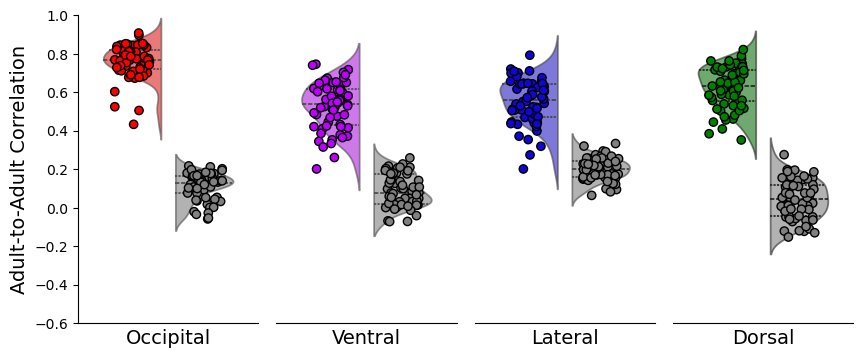

In [64]:
'''plot sub data at network level'''


#remove same region comparisons from df_summary_grouped and df_noise_grouped


#set network order
network_order = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
comp_order = ['same','different']
#comp_order = ['Same\nRegion','Same\nNetwork','Different\nNetwork']


#set network order as categorical and level order
df_network_summary['network_similarity'] = pd.Categorical(df_network_summary['network_similarity'], categories=comp_order, ordered=True)
#df_summary_grouped['infant_network'] = pd.Categorical(df_summary_grouped['infant_network'], categories=network_order, ordered=True)


#create list of 12 gray colors
network_colors = [['#fd0000','gray'], ['#be00fd', 'gray'], ['#1105d8', 'gray'], ['green', 'gray']]

#loop through networks and create subplot for each
#set subplot size
fig,ax = plt.subplots(1,4,figsize=(10,4),sharey=False)
for i in range(0,len(network_order)):
    #print(network_order[i])
    curr_data = df_network_summary[(df_network_summary['network1']==network_order[i]) & (df_network_summary['roi_similarity'] == 'same') | 
                                   (df_network_summary['network1']==network_order[i]) & (df_network_summary['network_similarity'] == 'different')]
    
    print(curr_data.groupby(['network1','network_similarity'])['corr'].mean())
    
    #add horizontal line at noise ceiling
    #ax[i].axhline(y=df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0], color = 'k', linestyle = '--')
    #add opaque rectangle behind noise ceiling with width of the standard deviation
    #ax[i].axhspan(df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]-df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
    #              df_noise_network.loc[df_noise_network['network1']==network_order[i],'corr'].values[0]+df_noise_network.loc[df_noise_network['network1']==network_order[i],'std'].values[0],
    #              alpha=0.2, color='k')
        
    #add horizontal line at mean
    #ax[i].axhline(y=curr_data[curr_data['roi_similarity']=='same']['corr'].mean(), color = 'r', linestyle = '--')
    
    #plot summary_df
    sns.violinplot(data=curr_data, x= 'network1', y= 'corr', hue='network_similarity',
                   split = True,gap = .2, alpha = .6, inner = 'quart', palette = network_colors[i], ax = ax[i])

    #set alpha for all artists
    #for artist in ax[i].artists:
    #    artist.set_alpha(.5)

    sns.stripplot(data = curr_data,  x= 'network1', y= 'corr', hue = 'network_similarity', 
                  dodge=True,edgecolor = 'black', alpha = 1, linewidth=1,jitter = .2, size = 6,
                    palette = network_colors[i], ax = ax[i])




    
    #increase font size of x and y ticks
    #plt.xticks(fontsize = 10)
    #plt.yticks(fontsize = 10)

    #set y limits
    ax[i].set_ylim([-.6,1])

    #add y label
    if i == 0:

        ax[i].set_ylabel('Adult-to-Adult Correlation', fontsize = 14)
        #make axes black
        ax[i].spines['left'].set_color('k')
        



    else:
        
        #remove y label
        ax[i].set_ylabel('')
        #remove y ticks
        ax[i].set_yticks([])
        #remove y tick labels
        ax[i].set_yticklabels([])
        #remove y axis line
        ax[i].spines['left'].set_visible(False)

    #remove x ticks and labels
    ax[i].set_xticks([])
    ax[i].set_xticklabels([])
    
    #add network as xlabel for each subplort
    ax[i].set_xlabel(network_order[i], fontsize = 14)
    #add x label
    #plt.xlabel('Network', fontsize = 20)

    #make axes black
    ax[i].spines['bottom'].set_color('k')
    

    #remove top and right axes
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)

    #remove legend
    ax[i].get_legend().remove()

    #print(curr_data.groupby(['infant_network','comparison'])['corr'].mean().reset_index())

plt.subplots_adjust(wspace=.1, hspace=0)

#save 
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation.png', bbox_inches='tight', dpi=300)

/home/vayzenb/anaconda3/envs/ml/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 0, '')

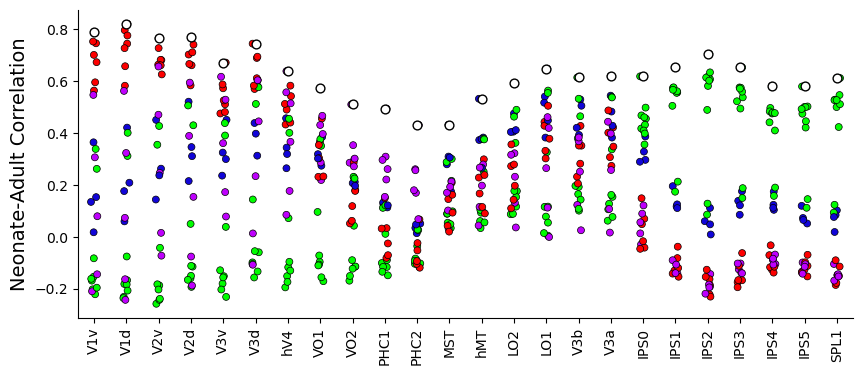

In [65]:
'''Plot data at roi level'''
network_colors = ['#fd0000','#be00fd', '#1105d8','#00fd00']
network_order= ['Occipital','Ventral','Lateral','Dorsal']

#set network order as categorical and level order
df_roi_summary['roi1'] = pd.Categorical(df_roi_summary['roi1'], categories=roi_labels['label'], ordered=True)
df_roi_summary['network2'] = pd.Categorical(df_roi_summary['network2'], categories=network_order, ordered=True)

df_roi_same = df_roi_summary[(df_roi_summary['roi1']==df_roi_summary['roi2']) & (df_roi_summary['roi_similarity'] == 'same')]



sns.scatterplot(data = df_roi_same, x = 'roi1', y = 'corr', color = 'white', linewidth = 1, s = 40, edgecolor = 'k', legend = False,zorder = 10)
sns.stripplot(data = df_roi_summary, x = 'roi1', y = 'corr', hue = 'network2', palette = network_colors, linewidth = .5, s = 5, edgecolor = 'k',jitter=.1,zorder = 0)


#create scatter plot of noise ceiling
#sns.scatterplot(data = df_noise_roi, x = 'roi1', y = 'corr', color = 'black', linewidth = 1, s = 100, marker="_", edgecolor = 'k', legend = False, zorder =15)

#remove legend
plt.legend([],[], frameon=False)

#change plot size
plt.gcf().set_size_inches(10,4)

#angle x axis labels
plt.xticks(rotation=90)

#remove top and right spines
sns.despine()

#add y axis label
plt.ylabel('Neonate-Adult Correlation', fontsize = 14)

#remove X axis label
plt.xlabel('')

#save
#plt.savefig(f'{git_dir}/figures/infant_adult_seed_correlation_roi.png', bbox_inches='tight', dpi=300)

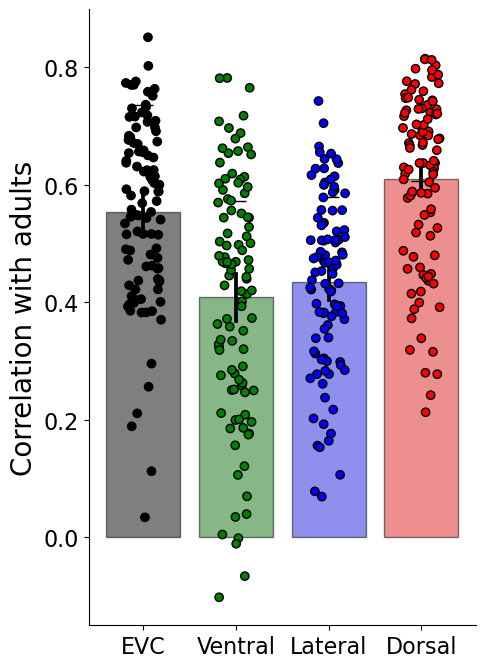

In [24]:
'''
Plot infant-adult correlations with adult noise ceilings
'''
summary_type = 'fc'
#load adult noise ceiling data
adult_noise_ceilings = pd.read_csv(f'{params.results_dir}/noise_ceilings/adult_{atlas}_{summary_type}_network_noise_ceilings.csv')

#load infant summary data

summary_df = pd.read_csv(f'{params.results_dir}/infant_adult_network_{summary_type}.csv')

#drop overall
summary_df = summary_df.drop(columns = ['overall'])

#plot
plot_network_corr(summary_df, noise_ceiling_df = adult_noise_ceilings)

### Age correlations

birth_age
Occipital: 0.28279862094440694 SignificanceResult(statistic=0.38105297611511874, pvalue=3.593702752913796e-22)
Ventral: 0.24285344886980054 SignificanceResult(statistic=0.2598168155751885, pvalue=3.7083414479688457e-09)
Lateral: 0.3949309604185954 SignificanceResult(statistic=0.43201012222509844, pvalue=1.2843161129469073e-19)
Dorsal: 0.37521416938842433 SignificanceResult(statistic=0.44979356606542353, pvalue=4.92922191476833e-46)
scan_age
Occipital: -0.13508691323934188 SignificanceResult(statistic=-0.14512712409447853, pvalue=0.00036197571435498706)
Ventral: -0.19709446498925096 SignificanceResult(statistic=-0.1698967795931897, pvalue=0.0001349279271623979)
Lateral: -0.24991590810758066 SignificanceResult(statistic=-0.1386962139694303, pvalue=0.00545794261876568)
Dorsal: -0.1717823259614787 SignificanceResult(statistic=-0.13966596487061353, pvalue=2.6133525484126236e-05)


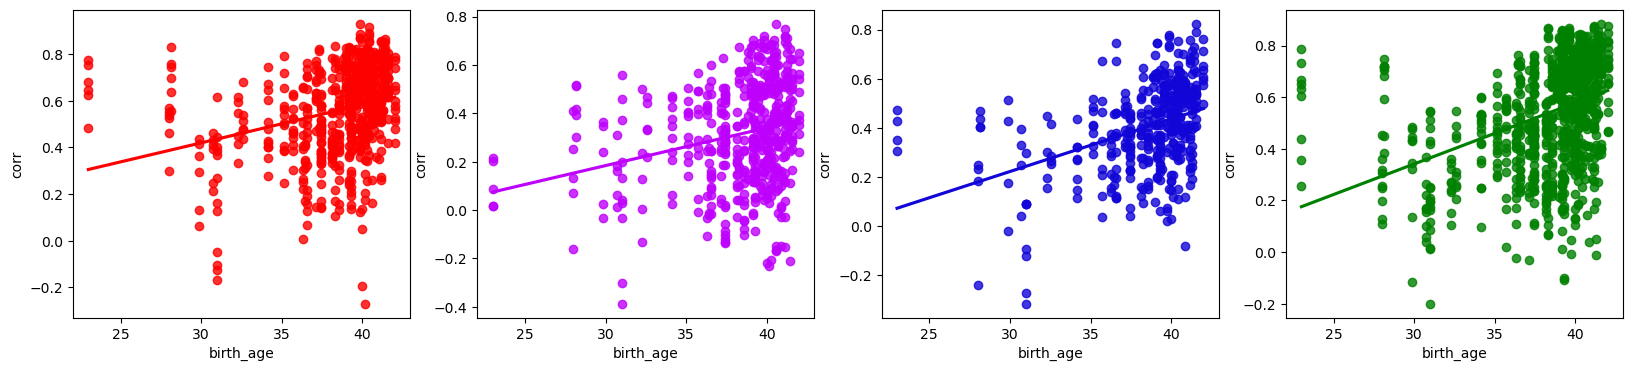

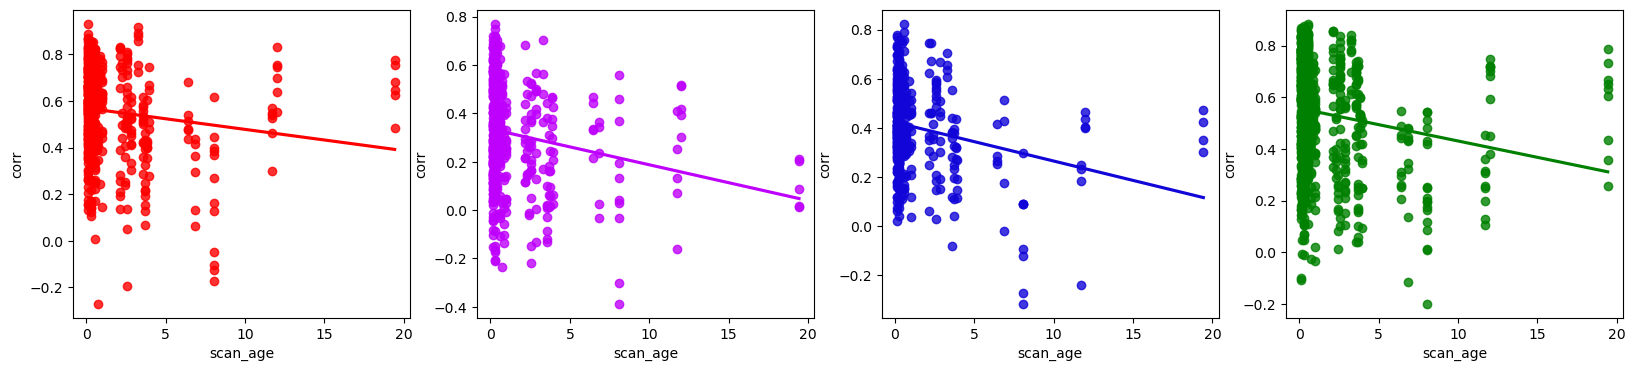

In [46]:
networks = ['Occipital', 'Ventral', 'Lateral', 'Dorsal']
df_summary_same = df_summary[df_summary['roi_similarity'] == 'same']
df_summary_same = df_summary_same.groupby(['sub','birth_age','scan_age','infant_network','infant_roi','roi_similarity'])['corr'].mean().reset_index()

age_types = ['birth_age','scan_age']

df_summary_same['scan_age'] = df_summary_same['scan_age'] - df_summary_same['birth_age']

for age_type in age_types:
    print(age_type)
    #append age to summary_df
    


    #create subplot for each network
    fig, ax = plt.subplots(1,len(networks), figsize = (20,4))
    for network in networks:
        curr_df = df_summary_same[df_summary_same['infant_network'] == network]
        #print correlation
        print(f'{network}: {np.corrcoef(curr_df[age_type], curr_df['corr'])[0,1]}', stats.spearmanr(curr_df[age_type], curr_df['corr']))
        #plot scatterplot with network color and trendline
        sns.regplot(data = curr_df, x = age_type, y = 'corr', color = network_colors[networks.index(network)], ax = ax[networks.index(network)], ci = None)

        

    #markersize = 15, markeredgecolor = 'k'